# 1. Representing Data

## Data as Vectors
Dataset with $N$ samples (row vectors) and $M$ features (column vectors):

\begin{align}
    X =
    \begin{pmatrix}
        x_{11} & x_{12} & \dots \\
        \vdots & \ddots & \\
        x_{n1} &        & x_{nm} 
    \end{pmatrix}
\end{align}

In supervised learning, the target (e.g. class in classification) is a column vector of length $N$:

\begin{align}
    Y = 
    \begin{pmatrix}
        y_{1} \\
        \vdots \\
        y_{n} 
    \end{pmatrix}
\end{align}

In [1]:
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('seaborn-darkgrid')

### Example: Wine Dataset

178 samples (wines), 13 features (chemical measurements). Type of the wine (0, 1, 2) as target (class).

In [2]:
wine = sklearn.datasets.load_wine()
df = pd.DataFrame(wine['data'], columns=wine['feature_names'])
df.loc[:, 'type'] = wine['target']
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,type
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


,proline,magnesium,type
0,1065.0,127.0,0
1,1050.0,100.0,0
2,1185.0,101.0,0
3,1480.0,113.0,0
4,735.0,118.0,0


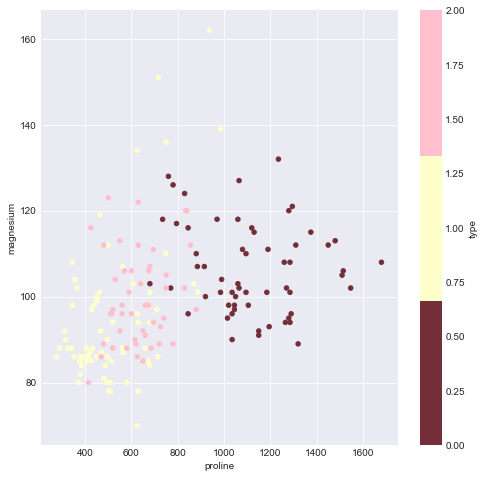

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))

df.plot.scatter(
    x='proline',
    y='magnesium',
    c='type',
    cmap=ListedColormap([(0.45, 0.18, 0.22), (1, 1, 0.8), (1, 0.75, 0.8)]),
    ax=ax
)

df[['proline', 'magnesium', 'type']].head()

## Feature Extraction

Deriving informative and non-redundant values out of raw data to facilitate the learning

* Feature engineering:
    * Manual work to figure out good features for data
    * Requires domain knowledge, testing, brainstorming and a lot of trial and error
* Feature learning:
    * Learning features automatically
    * Common with deep learning (neural networks)
* Dimensionality reduction
    * Reducing non-redundant information from data to reduce computational complexity
    * Selecting a subset of features or applying further feature extraction methods

## Example: Feature Engineering For Sound Data

In [4]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [5]:
def read_audio_file(filename):
    return wavfile.read(filename)

def plot_audio_spectrogram(filename):
    sample_rate, samples = read_audio_file(filename)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    
    with plt.style.context('default'):
        fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        axes[0].plot(1 / sample_rate * np.arange(len(samples)), samples)
        axes[1].pcolormesh(times, frequencies, 10*np.log10(spectrogram))
        axes[1].set_ylabel('Frequency')
        axes[1].set_xlabel('Time')
        plt.title(filename)
        plt.show()
        
    return ipd.Audio(filename)

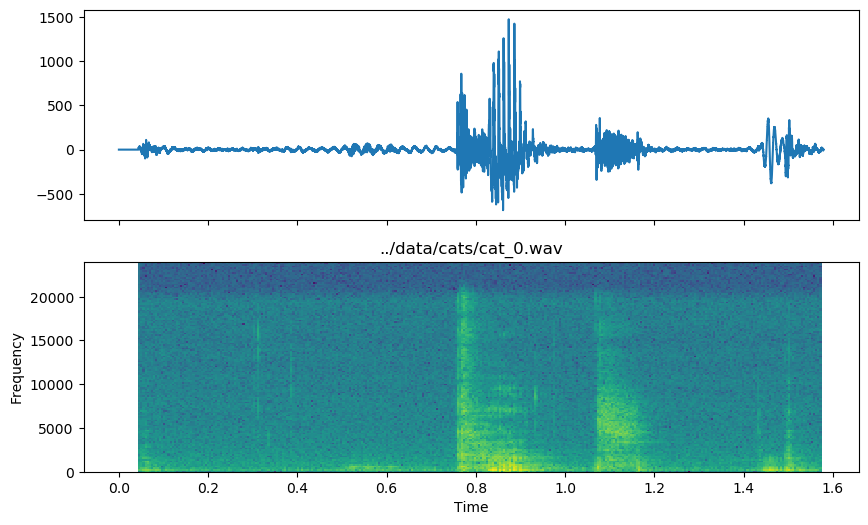

In [6]:
plot_audio_spectrogram('../data/cats/cat_0.wav')

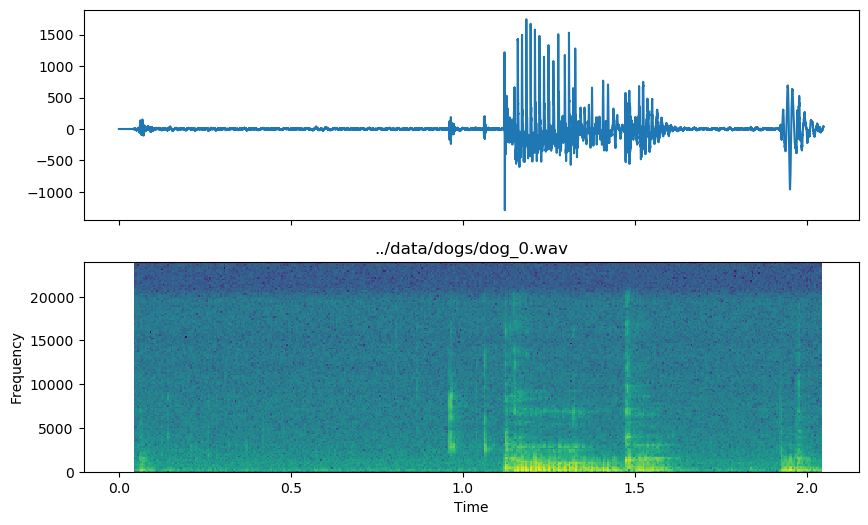

In [7]:
plot_audio_spectrogram('../data/dogs/dog_0.wav')

In [8]:
import glob
import os

def get_spectral_centroid(samples, sample_rate):
    magnitudes = np.abs(np.fft.rfft(samples))
    length = len(samples)
    freqs = np.abs(np.fft.fftfreq(length, 1.0 / sample_rate)[:(length // 2) + 1])
    return np.sum(magnitudes * freqs) / np.sum(magnitudes)

def get_zero_crossing_rate(samples, sample_rate):
    T = len(samples)
    return 1 / T * ((samples[:-1] * samples[1:]) < 0).sum()

def extract_features(filename):
    sample_rate, samples = read_audio_file(filename)
    return {
        'spectral_centroid': get_spectral_centroid(samples, sample_rate),
        'zero_crossing_rate': get_zero_crossing_rate(samples, sample_rate),
    }

def extract_features_from_files(filenames):
    features = pd.DataFrame(
        {
            'name': os.path.split(filename)[-1].split('.')[0],
            'filename': filename,
            'animal': 'dog' if 'dog' in filename else 'cat',
            **extract_features(filename)
        }
        for filename in filenames
    )
    return features.set_index('name').sort_index()

In [9]:
directories = ['cats', 'dogs']

cats_and_dogs = extract_features_from_files(
    glob.glob('../data/cats/*.wav') +
    glob.glob('../data/dogs/*.wav')
)

cats_and_dogs.head()

,filename,animal,spectral_centroid,zero_crossing_rate
name,,,,
cat_0,../data/cats/cat_0.wav,cat,3093.643030,0.072371
cat_1,../data/cats/cat_1.wav,cat,4054.879364,0.115797
cat_10,../data/cats/cat_10.wav,cat,2720.891116,0.090076
cat_11,../data/cats/cat_11.wav,cat,2805.827046,0.129699
cat_12,../data/cats/cat_12.wav,cat,2668.553457,0.119903


spectral_centroid                                                     \
                   count         mean         std          min          25%   
animal                                                                        
cat                 33.0  2854.889394  472.640758  2050.923647  2574.542903   
dog                 33.0  1187.225647  157.242907   865.272554  1064.183082   

                                              zero_crossing_rate            \
                50%          75%          max              count      mean   
animal                                                                       
cat     2805.827046  3224.731740  4054.879364               33.0  0.090455   
dog     1188.998159  1289.284057  1639.820759               33.0  0.116200   

                                                                    
             std       min       25%       50%       75%       max  
animal                                                              
cat     0.024975  0.045951  0.072371  0.086755  0.106466  0.153387  
dog     0.026729  0.075414  0.097288  0.108462  0.124752  0.187075

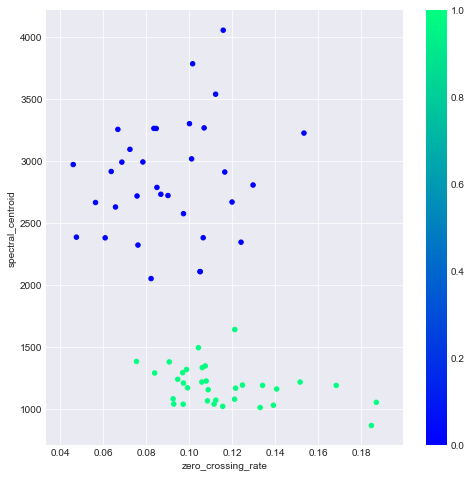

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

cats_and_dogs.plot.scatter(
    x='zero_crossing_rate',
    y='spectral_centroid',
    c=cats_and_dogs.animal == 'dog',
    cmap='winter',
    ax=ax
)

cats_and_dogs.groupby('animal').describe()

In [11]:
cats_and_dogs.to_csv('../data/cats_and_dogs.csv')
classification_test_data = extract_features_from_files(glob.glob('../data/test/*.wav'))
classification_test_data.to_csv('../data/test_cats_and_dogs.csv')
anomalies = extract_features_from_files(glob.glob('../data/anomalies/*.wav'))
anomalies.to_csv('../data/anomalies.csv')